# Car breakdown prediction

- **Name:**    **Deepa Kushwaha**

We have a fleet of automatic cars of same make & model. Since the drivers don't own the cars, they driver it abusively, which causes more wear and tear. All cars are equipped with sensors to provide the sate of the car on a daily basis (1 reading / day).

1. **Driving Mode sensors:**
The car has 3 different driving modes(Auto, City, Sports), which can be selected only once by the driver on a daily basis. The sensors though are not discrete and is captured as 3 different real numbers, captured as **ecoMode, cityMode, sportsMode**

2. **Engine Sensors**: 
Every is equipped with 21 different kind of sensors. (E.g. engine-rpm, engine-oil level, ac temperature, battery voltage, ...), captured as **s1, s2, s3, ..., s21**

#### What to predict ?

Given a timeseries data for every **vehicleId** and the day of failure. Can we predict that the break down is going to happen withing 30 days.

## Understanding the Data

**Loading Packages**

In [81]:
import pandas as pd                 # For DataFrames
import numpy as np                  # For mathematical calculations
import matplotlib.pyplot as plt     # For plotting graphs
import tensorflow as tf

In [82]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [83]:
%%html
<style>
table {float:left}
</style>

#### Training Data

In [84]:
train_data = pd.read_csv('data/car_breakdown_train.tsv', sep='\t', header=0)
train_data.head()

,vehicleId,days,ecoMode,cityMode,sportMode,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0007,-0.0004,100,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100,39.06,23.4190
1,1,2,0.0019,-0.0003,100,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100,39.00,23.4236
2,1,3,-0.0043,0.0003,100,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100,38.95,23.3442
3,1,4,0.0007,0.0000,100,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100,38.88,23.3739
4,1,5,-0.0019,-0.0002,100,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100,38.90,23.4044


In [85]:
print("Shape of train Dataset: ", train_data.shape)     #Rows= 20631, Col=26

Shape of train Dataset:  (20631, 26)


#### Test Data

In [86]:
test_data = pd.read_csv('data/car_breakdown_test.tsv', sep='\t', header=0)
test_data.head()

,vehicleId,days,ecoMode,cityMode,sportMode,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,0.0023,0.0003,100,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100,38.86,23.3735
1,1,2,-0.0027,-0.0003,100,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100,39.02,23.3916
2,1,3,0.0003,0.0001,100,518.67,642.46,1586.94,1401.34,14.62,...,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100,39.08,23.4166
3,1,4,0.0042,0.0000,100,518.67,642.44,1584.12,1406.42,14.62,...,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100,39.00,23.3737
4,1,5,0.0014,0.0000,100,518.67,642.51,1587.19,1401.92,14.62,...,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100,38.99,23.4130


In [87]:
print("Shape of test Dataset: ", test_data.shape)        ##Rows= 13096, Col=26

Shape of test Dataset:  (13096, 26)


##### How the test data is arranged.

Test data has the exactly same schema as the training data. Except the fact that the data doesn't represent when the failure has occurrs, in other words the last row for a given **vehicleId** doesn't represent the day of breakdown(it has happened earlier than the last row).

##### Ground truth test data

The **Remaining Useful Day(RUL)** as calculated from the first day for a particular **vehicleId** is present in the ground truth file.

In [88]:
# load the test data
test_truth_data = pd.read_csv('data/car_breakdown_test_truth.tsv', sep='\t', header=0)
test_truth_data.head()

,vehicleId,RUL
0,1,112
1,2,98
2,3,69
3,4,82
4,5,91


e.g. The **vehicleId** = 1 in the test data can run another 112 days before it fails.

In [89]:
print("Shape of truth_test Dataset: ", test_truth_data.shape)       ##Rows= 100, Col=2

Shape of truth_test Dataset:  (100, 2)


**Outliers and flat lines**

To know if there are outliers (extreme values) in the data, we could use descriptive statistics, train_data.describe().transpose(), and see if the min. and max. values are far away from the central tendency. As we can see below, this is not the case for any of the sensors.

However, if we look carefully we can see something else that is quite remarkable: there are several sensors where the min. and max. values are identical, and where the standard deviation (std) is zero. In time-series, this is called a flat line, which means there is no activity, possibly caused by sensor malfunctioning so drop the columns.

In [90]:
train_data.describe().transpose()             # overview the statitics of car_df part

,count,mean,std,min,25%,50%,75%,max
vehicleId,20631.0,51.506568,2.922763e+01,1.0000,26.0000,52.0000,77.0000,100.0000
days,20631.0,108.807862,6.888099e+01,1.0000,52.0000,104.0000,156.0000,362.0000
ecoMode,20631.0,-0.000009,2.187313e-03,-0.0087,-0.0015,0.0000,0.0015,0.0087
cityMode,20631.0,0.000002,2.930621e-04,-0.0006,-0.0002,0.0000,0.0003,0.0006
sportMode,20631.0,100.000000,0.000000e+00,100.0000,100.0000,100.0000,100.0000,100.0000
s1,20631.0,518.670000,6.537152e-11,518.6700,518.6700,518.6700,518.6700,518.6700
s2,20631.0,642.680934,5.000533e-01,641.2100,642.3250,642.6400,643.0000,644.5300
s3,20631.0,1590.523119,6.131150e+00,1571.0400,1586.2600,1590.1000,1594.3800,1616.9100
s4,20631.0,1408.933782,9.000605e+00,1382.2500,1402.3600,1408.0400,1414.5550,1441.4900
s5,20631.0,14.620000,3.394700e-12,14.6200,14.6200,14.6200,14.6200,14.6200


**The sensors s1, s5, s10, s16, s18, and s19 as well as sportMode, will for this reason be removed from further analyses:**

In [91]:
train_data.drop(['s1', 's5', 's10', 's16', 's18', 's19', 'sportMode'], axis=1, inplace=True)
test_data.drop(['s1', 's5', 's10', 's16', 's18', 's19', 'sportMode'], axis=1, inplace=True)

The distribution of the columns looks as follows:

### Exploratory Data Analysis  (EDA)

1. Univariate Analysis and
2. Bivariate Analysis

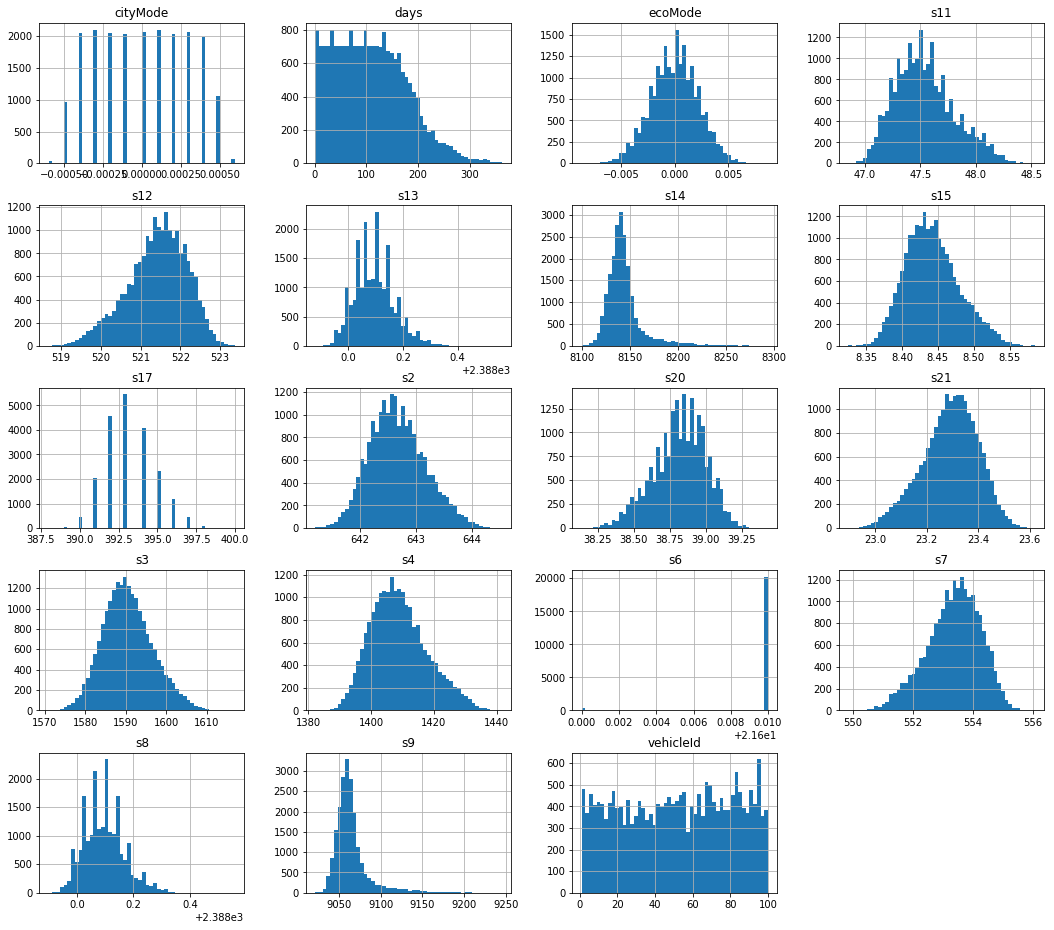

In [92]:
#Univariate Analysis
train_data.hist(bins=50, figsize=(18,16))
plt.show()

**Exploratory analyses of the max. number of days per vehicleId**

Exploratory data analyses provide insight into the cars engines in action. For example, it would be good to have an idea of the maximum lifetime of the 100 different vehicleId. The barplots below show that there is a large variation across vehicleId.

In [93]:
days_train = train_data.groupby('vehicleId', as_index=False)['days'].max()
days_test = test_data.groupby('vehicleId', as_index=False)['days'].max()

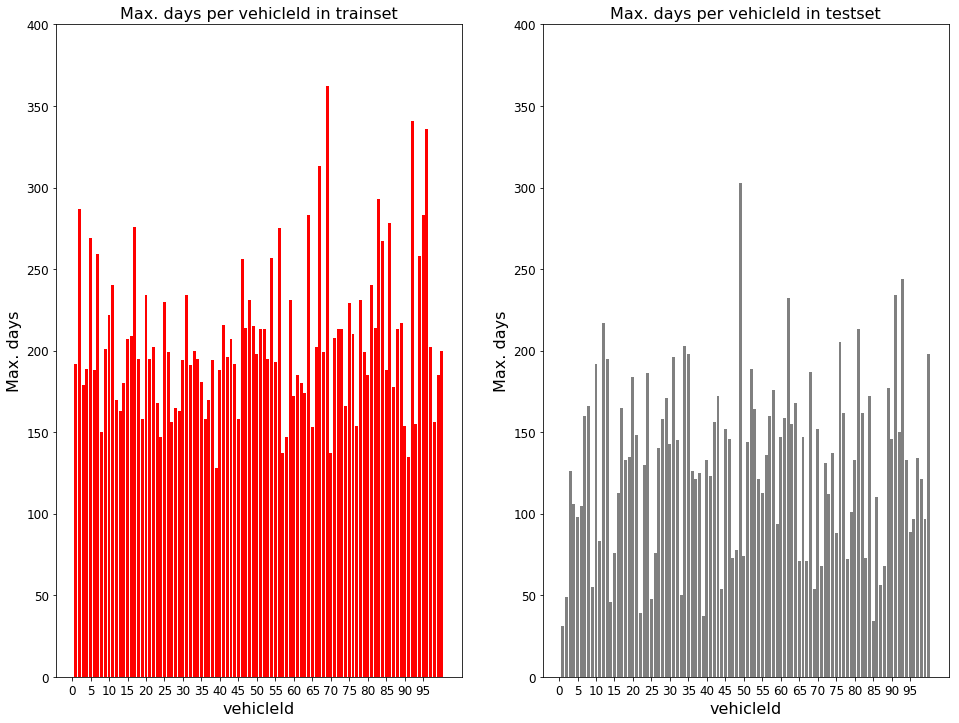

In [94]:
#Bivariate Analysis
fig = plt.figure(figsize = (16,12))
fig.add_subplot(1,2,1)
bar_labels = list(days_train['vehicleId'])
bars = plt.bar(list(days_train['vehicleId']), days_train['days'], color='red')
plt.ylim([0, 400])
plt.xlabel('vehicleId', fontsize=16)
plt.ylabel('Max. days', fontsize=16)
plt.title('Max. days per vehicleId in trainset', fontsize=16)
plt.xticks(np.arange(min(bar_labels)-1, max(bar_labels)-1, 5.0), fontsize=12)
plt.yticks(fontsize=12)
fig.add_subplot(1,2,2)
bars = plt.bar(list(days_test['vehicleId']), days_test['days'], color='grey')
plt.ylim([0, 400])
plt.xlabel('vehicleId', fontsize=16)
plt.ylabel('Max. days', fontsize=16)
plt.title('Max. days per vehicleId in testset', fontsize=16)
plt.xticks(np.arange(min(bar_labels)-1, max(bar_labels)-1, 5.0), fontsize=12)
plt.yticks(fontsize=12)
plt.show()

**Visualization of several sensors, for a particular vehicalId**

The following visualizes different sensors of a particular VehicleId. It gives a good impression that all sensors have a different range of values (as they measure different entities as speed, temperature), and that they do not all show an identical pattern or trend. In fact, some do increase in amplitude, while others decrease in amplitude over time.

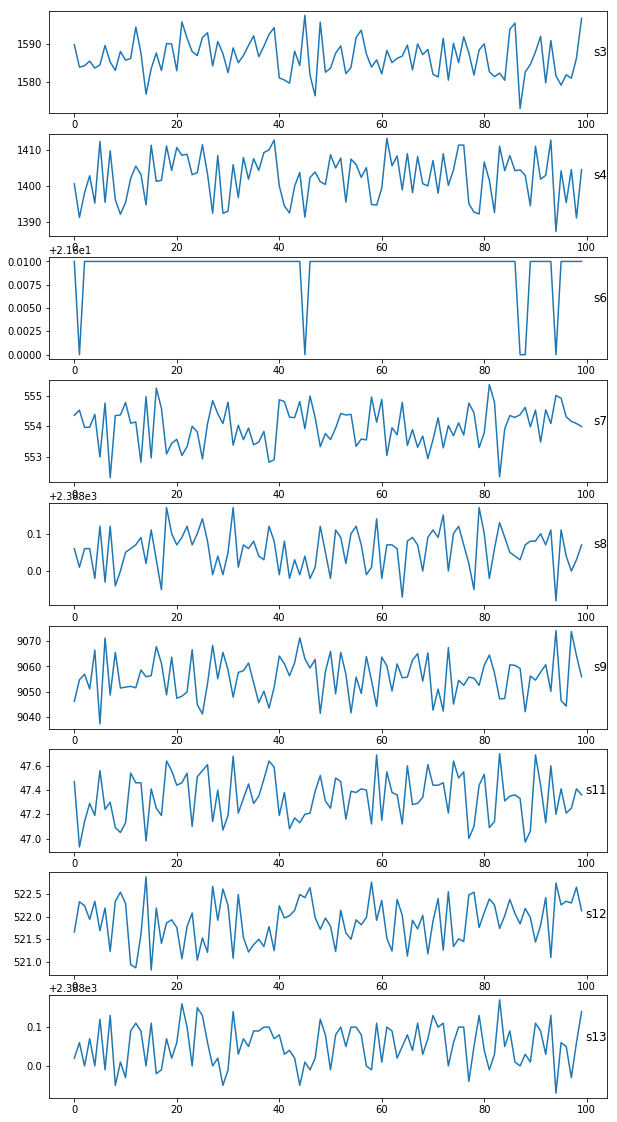

In [95]:
# Univariate Analysis
values = train_data[train_data.days==1].values
groups = [5, 6, 7, 8, 9, 10, 11,12,13]
i = 1
plt.figure(figsize=(10,20))
for group in groups:    
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(train_data.columns[group], y=0.5, loc='right')
    i += 1
plt.show()

We can also show a single sensor for different engine VehicleId. This nicely illustrates across VehicleId that amplitudes decrease over time and seem to go to a certain minimum threshold of about 551-552. By the way: the data seem rather noisy and filtering may help at some point (not treated in this blog).

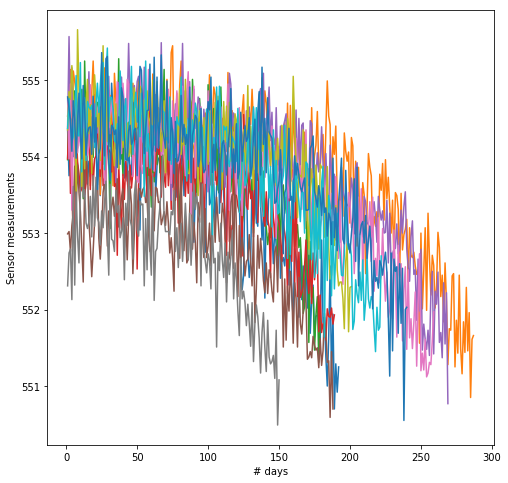

In [96]:
#Bivariate Analysis
plt.figure(figsize = (8, 8))
plt.plot(train_data[train_data.vehicleId==1].days, train_data[train_data.vehicleId==1].s7)
plt.plot(train_data[train_data.vehicleId==2].days, train_data[train_data.vehicleId==2].s7)
plt.plot(train_data[train_data.vehicleId==3].days, train_data[train_data.vehicleId==3].s7)
plt.plot(train_data[train_data.vehicleId==4].days, train_data[train_data.vehicleId==4].s7)
plt.plot(train_data[train_data.vehicleId==5].days, train_data[train_data.vehicleId==5].s7)
plt.plot(train_data[train_data.vehicleId==6].days, train_data[train_data.vehicleId==6].s7)
plt.plot(train_data[train_data.vehicleId==7].days, train_data[train_data.vehicleId==7].s7)
plt.plot(train_data[train_data.vehicleId==8].days, train_data[train_data.vehicleId==8].s7)
plt.plot(train_data[train_data.vehicleId==9].days, train_data[train_data.vehicleId==9].s7)
plt.plot(train_data[train_data.vehicleId==10].days, train_data[train_data.vehicleId==10].s7)
plt.plot(train_data[train_data.vehicleId==11].days, train_data[train_data.vehicleId==11].s7)
plt.xlabel('# days')
plt.ylabel('Sensor measurements')
plt.show()

So would it be possible that different VehicleId have a similar minimum and maximum value for single sensors? This would make sense if sensors started at a low amplitude (for ex. temperature) and went up to a high amplitude over time (or the other way around for other metrics). 

## Data Preparation & Feature engineering

#### Establishing RUL

It is now about time to determine the remaining useful Day (rul) for the testset, for each row. First, we determine in the testset for each row the max. Days for the particular VehicleId. We use the groupby command to obtain for every VehicleId the max. number of days.

In [97]:
test_truth_data.head()

,vehicleId,RUL
0,1,112
1,2,98
2,3,69
3,4,82
4,5,91


In [98]:
# generate column max for test data
rul_data = pd.DataFrame(test_data.groupby('vehicleId')['days'].max()).reset_index()
rul_data.columns = ['vehicleId', 'max']
rul_data.head()

,vehicleId,max
0,1,31
1,2,49
2,3,126
3,4,106
4,5,98


In [99]:
# run to failure

test_truth_data['rtf'] = test_truth_data['RUL'] + rul_data['max']
test_truth_data.head()

,vehicleId,RUL,rtf
0,1,112,143
1,2,98,147
2,3,69,195
3,4,82,188
4,5,91,189


In [100]:
test_truth_data.drop('RUL', axis=1, inplace=True)
test_data= test_data.merge(test_truth_data,on=['vehicleId'],how='left')
test_data['ttf']= test_data['rtf'] - test_data['days']
test_data.drop('rtf', axis=1, inplace=True)
test_data.head()

,vehicleId,days,ecoMode,cityMode,s2,s3,s4,s6,s7,s8,s9,s11,s12,s13,s14,s15,s17,s20,s21,ttf
0,1,1,0.0023,0.0003,643.02,1585.29,1398.21,21.61,553.90,2388.04,9050.17,47.20,521.72,2388.03,8125.55,8.4052,392,38.86,23.3735,142
1,1,2,-0.0027,-0.0003,641.71,1588.45,1395.42,21.61,554.85,2388.01,9054.42,47.50,522.16,2388.06,8139.62,8.3803,393,39.02,23.3916,141
2,1,3,0.0003,0.0001,642.46,1586.94,1401.34,21.61,554.11,2388.05,9056.96,47.50,521.97,2388.03,8130.10,8.4441,393,39.08,23.4166,140
3,1,4,0.0042,0.0000,642.44,1584.12,1406.42,21.61,554.07,2388.03,9045.29,47.28,521.38,2388.05,8132.90,8.3917,391,39.00,23.3737,139
4,1,5,0.0014,0.0000,642.51,1587.19,1401.92,21.61,554.16,2388.01,9044.55,47.31,522.15,2388.03,8129.54,8.4031,390,38.99,23.4130,138


**We then determine the time to failure (ttf) for every row, which is the number of days subtracted from the maximum number of days in a particular vehicleId.**

In [101]:
train_data['ttf'] = train_data.groupby(['vehicleId'])['days'].transform(max)-train_data['days']
train_data.head()

,vehicleId,days,ecoMode,cityMode,s2,s3,s4,s6,s7,s8,s9,s11,s12,s13,s14,s15,s17,s20,s21,ttf
0,1,1,-0.0007,-0.0004,641.82,1589.70,1400.60,21.61,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190,191
1,1,2,0.0019,-0.0003,642.15,1591.82,1403.14,21.61,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236,190
2,1,3,-0.0043,0.0003,642.35,1587.99,1404.20,21.61,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442,189
3,1,4,0.0007,0.0000,642.35,1582.79,1401.87,21.61,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,642.37,1582.85,1406.22,21.61,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044,187


In [102]:
df_train=train_data.copy()
df_test=test_data.copy()
period=30
df_train['label_dummy'] = df_train['ttf'].apply(lambda x: 1 if x <= period else 0)
df_test['label_dummy'] = df_test['ttf'].apply(lambda x: 1 if x <= period else 0)
df_train.head()

,vehicleId,days,ecoMode,cityMode,s2,s3,s4,s6,s7,s8,...,s11,s12,s13,s14,s15,s17,s20,s21,ttf,label_dummy
0,1,1,-0.0007,-0.0004,641.82,1589.70,1400.60,21.61,554.36,2388.06,...,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190,191,0
1,1,2,0.0019,-0.0003,642.15,1591.82,1403.14,21.61,553.75,2388.04,...,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236,190,0
2,1,3,-0.0043,0.0003,642.35,1587.99,1404.20,21.61,554.26,2388.08,...,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442,189,0
3,1,4,0.0007,0.0000,642.35,1582.79,1401.87,21.61,554.45,2388.11,...,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739,188,0
4,1,5,-0.0019,-0.0002,642.37,1582.85,1406.22,21.61,554.00,2388.06,...,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044,187,0


In [103]:
features_col_name=['ecoMode', 'cityMode', 's2', 's3', 's4','s6', 's7', 's8', 's9','s11',
                         's12', 's13', 's14', 's15', 's17', 's20', 's21']
target_col_name='label_dummy'

#### Features Scaling

- Another preparatory step that is important is scaling. We are going to use the MinMaxScaler in Python:

In [104]:
from sklearn.preprocessing import MinMaxScaler
sc=MinMaxScaler()


Before scaling, let us inspect the original descriptive statistics. This shows that there are huge differences between multiple sensors in minimum and maximum values,as expected since the sensors measure different entities (such as temperature, speed):

In [105]:
df_train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
vehicleId,20631.0,51.506568,29.227633,1.0000,26.0000,52.0000,77.0000,100.0000
days,20631.0,108.807862,68.880990,1.0000,52.0000,104.0000,156.0000,362.0000
ecoMode,20631.0,-0.000009,0.002187,-0.0087,-0.0015,0.0000,0.0015,0.0087
cityMode,20631.0,0.000002,0.000293,-0.0006,-0.0002,0.0000,0.0003,0.0006
s2,20631.0,642.680934,0.500053,641.2100,642.3250,642.6400,643.0000,644.5300
s3,20631.0,1590.523119,6.131150,1571.0400,1586.2600,1590.1000,1594.3800,1616.9100
s4,20631.0,1408.933782,9.000605,1382.2500,1402.3600,1408.0400,1414.5550,1441.4900
s6,20631.0,21.609803,0.001389,21.6000,21.6100,21.6100,21.6100,21.6100
s7,20631.0,553.367711,0.885092,549.8500,552.8100,553.4400,554.0100,556.0600
s8,20631.0,2388.096652,0.070985,2387.9000,2388.0500,2388.0900,2388.1400,2388.5600


In [106]:
df_train[features_col_name]=sc.fit_transform(df_train[features_col_name])
df_test[features_col_name]=sc.transform(df_test[features_col_name])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


#### Function to reshape dataset as required by LSTM

In [107]:
def gen_sequence(id_df, seq_length, seq_cols):
    df_zeros=pd.DataFrame(np.zeros((seq_length-1,id_df.shape[1])),columns=id_df.columns)
    id_df=df_zeros.append(id_df,ignore_index=True)
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    lstm_array=[]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        lstm_array.append(data_array[start:stop, :])
    return np.array(lstm_array)

# function to generate labels
def gen_label(id_df, seq_length, seq_cols,label):
    df_zeros=pd.DataFrame(np.zeros((seq_length-1,id_df.shape[1])),columns=id_df.columns)
    id_df=df_zeros.append(id_df,ignore_index=True)
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    y_label=[]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        y_label.append(id_df[label][stop])
    return np.array(y_label)

In [108]:
# timestamp or window size

seq_length=50
seq_cols=features_col_name

#### Neural network in Keras

We are now ready to train the data and predict the RUL data. For this we are using Keras. Importantly, for the target variable y_train, we take the fraction of the time to failure TTF. The features are the scaled values. Note that the data are in Numpy.ndarray format, which can be checked by type(X_train)

In [29]:
# generate X_train
X_train=np.concatenate(list(list(gen_sequence(df_train[df_train['vehicleId']==id], seq_length, seq_cols)) for id in df_train['vehicleId'].unique()))
print(X_train.shape)

# generate y_train
y_train=np.concatenate(list(list(gen_label(df_train[df_train['vehicleId']==id], 50, seq_cols,'label_dummy')) for id in df_train['vehicleId'].unique()))
print(y_train.shape)

(20531, 50, 17)
(20531,)


In [30]:
# generate X_test
X_test=np.concatenate(list(list(gen_sequence(df_test[df_test['vehicleId']==id], seq_length, seq_cols)) for id in df_test['vehicleId'].unique()))
print(X_test.shape)
# generate y_test
y_test=np.concatenate(list(list(gen_label(df_test[df_test['vehicleId']==id], 50, seq_cols,'label_dummy')) for id in df_test['vehicleId'].unique()))
print(y_test.shape)

(12996, 50, 17)
(12996,)


## Model Building

#### LSTM Network

In [31]:
from sklearn.metrics import confusion_matrix,accuracy_score
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation
from keras.callbacks import EarlyStopping

nb_features =X_train.shape[2]
timestamp=seq_length

model = Sequential()

model.add(LSTM(
         input_shape=(timestamp, nb_features),
         units=100,
         return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
          units=50,
          return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Instructions for updating:
Colocations handled automatically by placer.


Using TensorFlow backend.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50, 100)           47200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 100)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 77,451
Trainable params: 77,451
Non-trainable params: 0
_________________________________________________________________


In [32]:
# fit the network

model.fit(X_train, y_train, epochs=10, batch_size=200, validation_split=0.05, verbose=1,
          callbacks = [EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto')])

Instructions for updating:
Use tf.cast instead.
Train on 19504 samples, validate on 1027 samples
Epoch 1/10
19504/19504 [==============================] - 30s 2ms/step - loss: 0.2037 - acc: 0.9183 - val_loss: 0.0977 - val_acc: 0.9630
Epoch 2/10
19504/19504 [==============================] - 29s 2ms/step - loss: 0.0816 - acc: 0.9666 - val_loss: 0.0589 - val_acc: 0.9766
Epoch 3/10
19504/19504 [==============================] - 30s 2ms/step - loss: 0.0719 - acc: 0.9698 - val_loss: 0.0552 - val_acc: 0.9805
Epoch 4/10
19504/19504 [==============================] - 30s 2ms/step - loss: 0.0636 - acc: 0.9734 - val_loss: 0.0369 - val_acc: 0.9873
Epoch 5/10
19504/19504 [==============================] - 29s 1ms/step - loss: 0.0613 - acc: 0.9739 - val_loss: 0.0446 - val_acc: 0.9834


In [37]:
# training metrics
scores = model.evaluate(X_train, y_train, verbose=1, batch_size=200)
print('Accurracy: {}'.format(scores[1]))

20531/20531 [==============================] - 8s 391us/step
Accurracy: 0.9760849504805036


#### Prediction

In [38]:
y_pred=model.predict_classes(X_test)
print('Accuracy of model on test data: ',accuracy_score(y_test,y_pred))
print('Confusion Matrix: \n',confusion_matrix(y_test,y_pred))

Accuracy of model on test data:  0.9903816558941213
Confusion Matrix: 
 [[12633    31]
 [   94   238]]


#### Probability of failure

In [68]:
def prob_failure(engine_vehicleId):

    engine_df=df_test[df_test.vehicleId==engine_vehicleId]
    engine_test=gen_sequence(engine_df,seq_length,seq_cols)
    m_pred=model.predict(engine_test)
    failure_prob=list(m_pred[-1]*100)[0]
    return failure_prob
prob_failure

<function __main__.prob_failure(engine_vehicleId)>

### Car breakdown Prediction happened withing 30 days(probability)

In [78]:
engine_vehicleId= 32      # engine_vehicleId= you can input the VehicleId range(1,2,3,4......99) 

print('Probability that engine will fail within 30 days:',prob_failure(engine_vehicleId))

Probability that engine will fail within 30 days: 0.22213459
